# Medical insurance price prediction using various regression techniques

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from pickle import dump
from feature_engine.outliers import ArbitraryOutlierCapper
import numpy as np

Define important functions: for preprocessing of the data, for evaluation and for ploting of features importance

In [23]:
# Function to preprocess data
def preprocess_data(data):
    data.drop_duplicates(inplace=True)
    
    # Encode categorical features
    data['sex'] = data['sex'].map({'male': 0, 'female': 1})
    data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
    data['region'] = data['region'].map({'northwest': 0, 'northeast': 1, 'southeast': 2, 'southwest': 3})

    # Outlier handling for 'bmi'
    Q1, Q3 = data['bmi'].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    low_lim, up_lim = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    arb = ArbitraryOutlierCapper(min_capping_dict={'bmi': low_lim}, max_capping_dict={'bmi': up_lim})
    data[['bmi']] = arb.fit_transform(data[['bmi']])
    return data

# Function to evaluate models
def evaluate_model(model, xtrain, xtest, ytrain, ytest, name):
    model.fit(xtrain, ytrain)
    ypred_train = model.predict(xtrain)
    ypred_test = model.predict(xtest)
    
    # Metrics
    metrics = {
        "Train R2": r2_score(ytrain, ypred_train),
        "Test R2": r2_score(ytest, ypred_test),
        "MAE": mean_absolute_error(ytest, ypred_test),
        "RMSE": np.sqrt(mean_squared_error(ytest, ypred_test)),
        "CV R2": cross_val_score(model, X, Y, cv=5).mean()
    }
    print(f"{name} Metrics:\n", metrics)
    return metrics

# Function to visualize feature importance
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        sns.barplot(x=importance, y=feature_names)
        plt.title(title)
        plt.show()

In [24]:
# Load and preprocess data
data = pd.read_csv("data/med_insurance.csv")
data.head()
data = preprocess_data(data)

Normalize and split the data

In [25]:
# Split features and target
X = data.drop(['charges'], axis=1)
Y = data['charges']

# Scale numerical features
scaler = StandardScaler()
X[['age', 'bmi', 'children']] = scaler.fit_transform(X[['age', 'bmi', 'children']])

# Split dataset
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.2, random_state=42)

Define the models

In [26]:
# Models and hyperparameter grids
models = {
    "Linear Regression": LinearRegression(),
    "SVR": SVR(),
    "Random Forest": RandomForestRegressor(random_state=42, n_estimators=100),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor()
}

Train the models and evaluate them


Linear Regression:
Linear Regression Metrics:
 {'Train R2': 0.7295415541376445, 'Test R2': 0.8062391115570589, 'MAE': 4190.091643948692, 'RMSE': 5966.970607048556, 'CV R2': 0.7470697972809901}

SVR:
SVR Metrics:
 {'Train R2': -0.10047051880833502, 'Test R2': -0.13346366828118073, 'MAE': 9263.777136425862, 'RMSE': 14431.93758360034, 'CV R2': -0.10266187754253217}

Random Forest:
Random Forest Metrics:
 {'Train R2': 0.9740257276510202, 'Test R2': 0.880255912392719, 'MAE': 2619.215388400746, 'RMSE': 4690.810402361891, 'CV R2': 0.83707539475551}


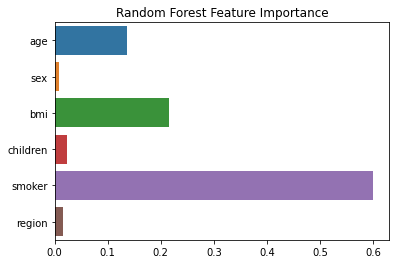


Gradient Boosting:
Gradient Boosting Metrics:
 {'Train R2': 0.8931345821166041, 'Test R2': 0.9042374023218575, 'MAE': 2428.376438278739, 'RMSE': 4194.872826640492, 'CV R2': 0.8550893452847912}


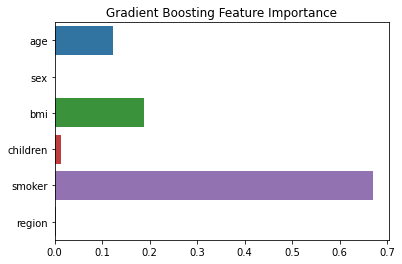


XGBoost:
XGBoost Metrics:
 {'Train R2': 0.9944530188818493, 'Test R2': 0.8608160554081113, 'MAE': 2882.000565894779, 'RMSE': 5057.261495702978, 'CV R2': 0.811322622871731}


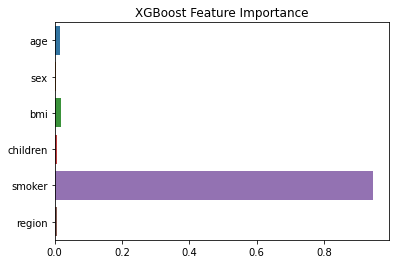

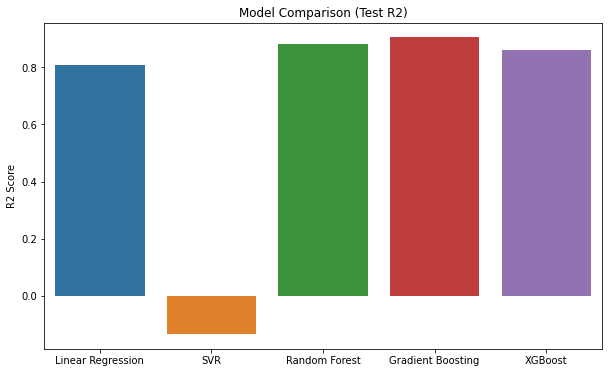

In [27]:
metrics = {}

# Evaluate each model
for name, model in models.items():
    print(f"\n{name}:")
    metrics[name] = evaluate_model(model, xtrain, xtest, ytrain, ytest, name)
    if name in ["Random Forest", "Gradient Boosting", "XGBoost"]:
        plot_feature_importance(model, X.columns, f"{name} Feature Importance")

# Save the best model 
dump(models["Gradient Boosting"], open('insurance_model.pkl', 'wb'))

# Visualize overall performance
plt.figure(figsize=(10, 6))
sns.barplot(x=list(metrics.keys()), y=[m["Test R2"] for m in metrics.values()])
plt.title("Model Comparison (Test R2)")
plt.ylabel("R2 Score")
plt.show()

Test how Gradient Boosting performs (best from all models). Gradient Boosting and Random Forest perform best, because all the features are important for their predictions.

In [28]:
# Test prediction
new_data = pd.DataFrame({'age': 19, 'sex': 0, 'bmi': 27.9, 'children': 0, 'smoker': 1, 'region': 1}, index=[0])
new_data[['age', 'bmi', 'children']] = scaler.transform(new_data[['age', 'bmi', 'children']])
predicted_charge = models["Gradient Boosting"].predict(new_data)
print(f"Predicted charge for new data: {predicted_charge[0]}")

Predicted charge for new data: 17756.51390169379
